# Wykop - Links - Analysis

**Questions**

1. What is the minimal number of votes required to be in the first 10/20/50/100 of the most popular links?
2. What are the most popular tags?
3. What are the most popular sources?
4. Which tags go together the most?
5. What are the most popular words in titles?
6. Which users' links are the most upvoted?

## Setup

In [18]:
import glob
import json
import random
import datetime
from collections import Counter

from wordcloud import WordCloud

from scipy import stats
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

In [209]:
# wykop.pl colors

wykop_orange = '#f58237'
wykop_blue = '#367da9'

## Utils

In [20]:
def read_link(filepath):
    with open(filepath, 'r') as f:
        content = f.read()
    return json.loads(content)

## Data

### Download Data

Data was downloaded with the script ./bin/download_hits.py

In [15]:
!ls links

2006  2008  2010  2012	2014  2016  2018  2020
2007  2009  2011  2013	2015  2017  2019  2021


### Data Processing

In [16]:
dataset_path = 'links/'

In [17]:
link_files = list(glob.iglob(dataset_path + '**/*.json', recursive=True))
random.shuffle(link_files)

print(f'There are {len(link_files)} records in the dataset.')

There are 339033 records in the dataset.


In [21]:
df_links = pd.DataFrame([read_link(link_file) for link_file in tqdm(link_files)])

df_links['tags'] = df_links['tags'].apply(lambda x: x.split() if isinstance(x, str) else None)

df_links['date'] = pd.to_datetime(df_links['date'], format='%Y-%m-%d %H:%M:%S')
df_links['year'] = df_links['date'].dt.year
df_links['month'] = df_links['date'].dt.month

df_links = df_links[df_links.tags.notnull()]

  0%|          | 0/339033 [00:00<?, ?it/s]

In [24]:
df_links.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339032 entries, 0 to 339032
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   id              339032 non-null  int64         
 1   title           339031 non-null  object        
 2   description     339028 non-null  object        
 3   tags            339032 non-null  object        
 4   source_url      339032 non-null  object        
 5   vote_count      339032 non-null  int64         
 6   bury_count      339032 non-null  int64         
 7   comments_count  339032 non-null  int64         
 8   related_count   339032 non-null  int64         
 9   date            339032 non-null  datetime64[ns]
 10  author          339032 non-null  object        
 11  preview         306422 non-null  object        
 12  plus18          339032 non-null  bool          
 13  status          339032 non-null  object        
 14  can_vote        339032 non-null  boo

In [22]:
df_links.head()

,id,title,description,tags,source_url,vote_count,bury_count,comments_count,related_count,date,...,preview,plus18,status,can_vote,is_hot,archived,app,info,year,month
0,4857655,Wypadek na S8,Ciągnik siodłowy bez wiadomej przyczyny zjecha...,"[#polska, #warszawa, #wypadek]",http://www.youtube.com/watch?v=XqGX89Y9klI,749,0,132,4,2019-03-22 00:49:37,...,https://www.wykop.pl/cdn/c3397993/link_MxwMiq7...,False,promoted,True,False,NaN,NaN,NaN,2019,3
1,168825,Obrazkowe porównania,"Doktryny polityczne, przesłania kulturowe, pra...","[#swiat, #obrazkowe, #porownaia, #ciekawostki,...",http://dirty.ru/comments/236164,545,36,45,3,2009-04-12 21:53:31,...,"https://www.wykop.pl/cdn/c3397993/link_168825,...",False,promoted,True,False,True,NaN,NaN,2009,4
2,4018403,Listopadowy poranek na Śnieżce.,Piękne zdjęcia ze Śnieżkki,[#polska],http://www.karkonosze.pl/listopadowy-poranek-n...,425,1,64,1,2017-11-15 19:35:43,...,https://www.wykop.pl/cdn/c3397993/link_YCVB3nr...,False,promoted,True,False,NaN,NaN,NaN,2017,11
3,3859765,"Tajemnicze ludzkie gatunki, które wyginęły",Nie zawsze byliśmy tylko jedynym gatunkiem czł...,"[#swiat, #nauka, #biologia, #ciekawostki, #zai...",http://www.youtube.com/watch?v=BwQWNpgdP6U,366,9,94,1,2017-08-05 09:49:22,...,https://www.wykop.pl/cdn/c3397993/link_8ivPORq...,False,promoted,True,False,NaN,NaN,NaN,2017,8
4,5393233,"Idziemy śladem Włoch, młodzież ma gdzieś wirusa",Oto w jaki sposób rząd radzi sobie z epidemią ...,"[#koronawirus, #polska, #warszawa]",https://m.facebook.com/story.php?story_fbid=10...,1031,54,265,2,2020-03-19 01:04:13,...,NaN,False,promoted,True,False,NaN,Android,NaN,2020,3


## Analysis

#### What is the minimal number of votes required to be in the first 10/20/50/100 of the most popular links?

In [194]:
df = df_links

In [195]:
# rank links by number of votes within a single month
df['rank'] = df.groupby(by=['year', 'month'])['vote_count'] \
    .transform(lambda x: x.rank(method='first', ascending=False))

In [196]:
def get_min_votes_df(top_n):
    df_min_votes = df[df['rank'] == top_n] \
        .sort_values(['year', 'month'])[['year', 'month', 'vote_count']]
    df_min_votes['period'] = df_min_votes.apply(lambda x: datetime.datetime(x.year, x.month, 1), axis=1)
    return df_min_votes

In [197]:
df_top5_min_votes = get_min_votes_df(5)
df_top10_min_votes = get_min_votes_df(10)
df_top20_min_votes = get_min_votes_df(20)
df_top50_min_votes = get_min_votes_df(50)

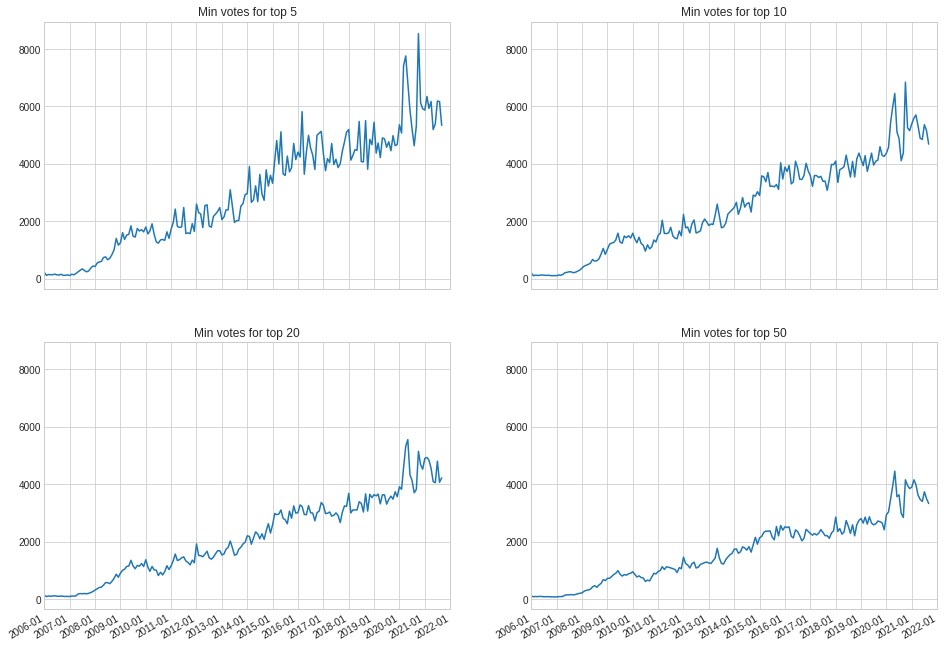

In [198]:
fig, axes = plt.subplots(ncols=2, nrows=2, sharex='all', sharey='all', figsize=(16, 12))

axes[0,0].plot('period', 'vote_count', data=df_top5_min_votes)
axes[0,1].plot('period', 'vote_count', data=df_top10_min_votes)
axes[1,0].plot('period', 'vote_count', data=df_top20_min_votes)
axes[1,1].plot('period', 'vote_count', data=df_top50_min_votes)

fmt_half_year = mdates.MonthLocator(interval=12)
axes[0,0].xaxis.set_major_locator(fmt_half_year)

fmt_month = mdates.MonthLocator() 
axes[0,0].xaxis.set_minor_locator(fmt_month)
axes[0,0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

datemin = np.datetime64(df_top5_min_votes['period'].iloc[0], 'Y')
datemax = np.datetime64(df_top5_min_votes['period'].iloc[-1], 'Y') + np.timedelta64(1, 'Y')
axes[0,0].set_xlim(datemin, datemax)

axes[0,0].grid(True)
axes[0,1].grid(True)
axes[1,0].grid(True)
axes[1,1].grid(True)

axes[0,0].title.set_text('Min votes for top 5')
axes[0,1].title.set_text('Min votes for top 10')
axes[1,0].title.set_text('Min votes for top 20')
axes[1,1].title.set_text('Min votes for top 50')

for ax in axes.flatten():
    ax.yaxis.set_tick_params(labelleft=True)
    
fig.autofmt_xdate()

plt.savefig('images/min_votes.png', dpi=100, transparent=False, bbox_inches='tight')
plt.show()

#### What are the most popular tags?

In [89]:
links_by_year = df_links.groupby(['year']).agg(total_links=('id', 'count'))

In [90]:
df_tags = df_links[['id', 'year', 'tags']].explode(['tags']) \
    .rename(columns={'tags': 'tag'}) \
    .groupby(['year', 'tag']) \
    .agg(n=('id', 'count'))

df_tags['rank'] = df_tags.groupby(by=['year'])['n'] \
    .transform(lambda x: x.rank(method='first', ascending=False))

df_tags['n_perc'] = df_tags.join(links_by_year).apply(lambda x: x.n/x.total_links, axis=1)

df_tags.reset_index(inplace=True)

In [217]:
df_popular = df_tags[(df_tags['rank'] <= 10) & (df_tags['year'].isin([2008, 2021]))].reset_index()
df_popular['item'] = df_popular.apply(lambda x: (x.tag, x.n_perc), axis=1)

labels = df_popular['tag'].unique().tolist()

df_popular = df_tags[df_tags['tag'].isin(labels)]

tags_ref = {
    record['tag']: record['n_perc']
    for record in df_popular[df_popular['year'] == 2008][['tag', 'n_perc']].to_dict('records')
}

tags_new = {
    record['tag']: record['n_perc']
    for record in df_popular[df_popular['year'] == 2021][['tag', 'n_perc']].to_dict('records')
}

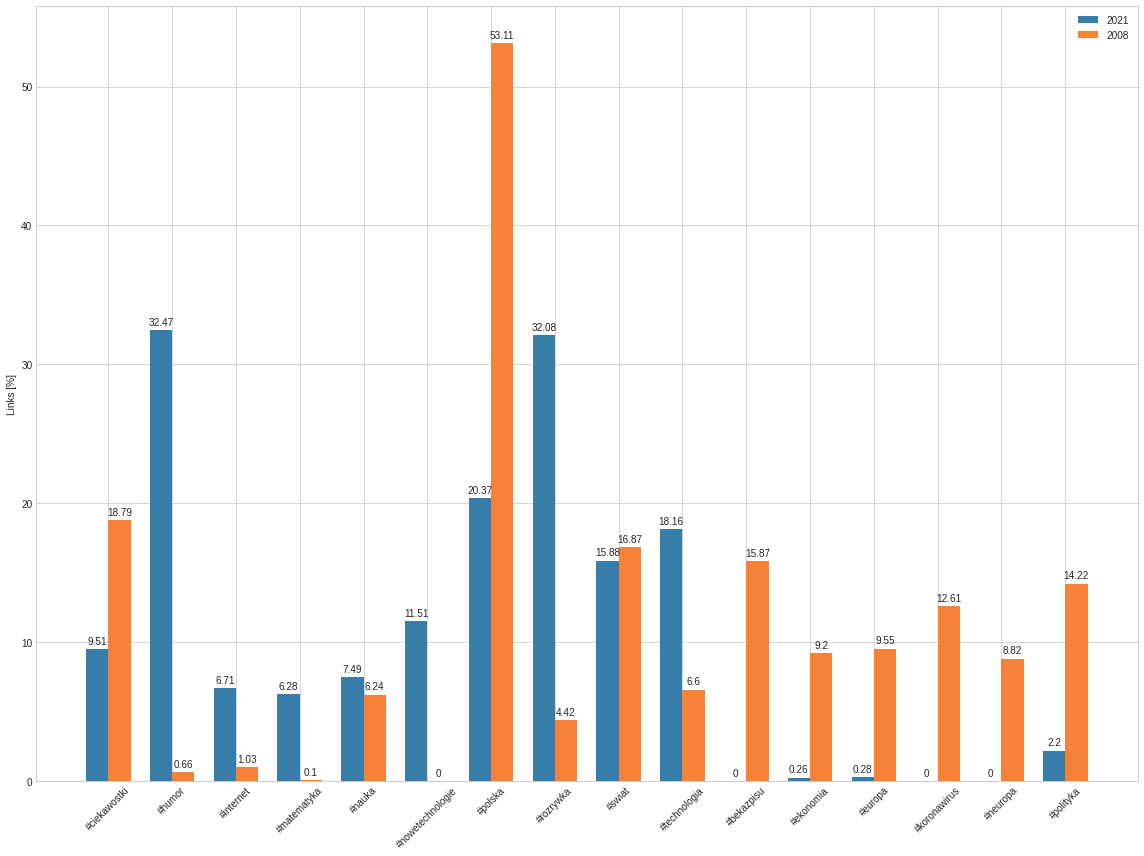

In [218]:
tags_ref = [ round(100*tags_ref.get(label, 0.0), 2) for label in labels ]
tags_new = [ round(100*tags_new.get(label, 0.0), 2) for label in labels ]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(16, 12))
rects1 = ax.bar(x - width/2, tags_ref, width, label='2021', color=wykop_blue)
rects2 = ax.bar(x + width/2, tags_new, width, label='2008', color=wykop_orange)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Links [%]')
# ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.savefig('images/popular_tags_shift.png', dpi=100, transparent=False, bbox_inches='tight')
plt.show()

In [176]:
df_popular = df_tags[df_tags['rank'] <= 5].reset_index()
df_popular['item'] = df_popular.apply(lambda x: (x.tag, x.n_perc), axis=1)

for year, tags in df_popular.groupby(['year'])['item'].apply(list).items():
    print(year, ' ', end='')
    for tag, share in sorted(tags, key=lambda x: x[1], reverse=True):
        print('{:.1f}% - {:15.10s}'.format(100*share, tag), end='')
    print()

2006  43.2% - #technolog     25.9% - #nowetechn     23.7% - #humor         22.9% - #rozrywka      17.1% - #internet      
2007  32.2% - #humor         31.7% - #rozrywka      25.3% - #technolog     19.7% - #polska        16.1% - #nowetechn     
2008  32.5% - #humor         32.1% - #rozrywka      20.4% - #polska        18.2% - #technolog     15.9% - #swiat         
2009  28.1% - #polska        27.6% - #rozrywka      27.5% - #humor         19.0% - #swiat         11.8% - #technolog     
2010  21.2% - #polska        11.8% - #rozrywka      10.7% - #swiat         9.4% - #humor         9.2% - #nauka         
2011  15.3% - #zainteres     15.2% - #polska        12.8% - #rozrywka      11.6% - #nauka         11.3% - #ciekawost     
2012  24.1% - #polska        14.8% - #zainteres     14.1% - #nauka         10.6% - #ciekawost     8.9% - #rozrywka      
2013  39.2% - #polska        24.5% - #ciekawost     17.5% - #swiat         13.3% - #zainteres     12.6% - #rozrywka      
2014  47.7% - #polska      

In [193]:
df_popular = df_tags[df_tags['rank'] <= 10].reset_index()
popular_tags = df_popular['tag'].unique().tolist()
df_popular = df_tags[df_tags['tag'].isin(popular_tags)]

df_popular.to_csv('popular_tags.csv', index=False)

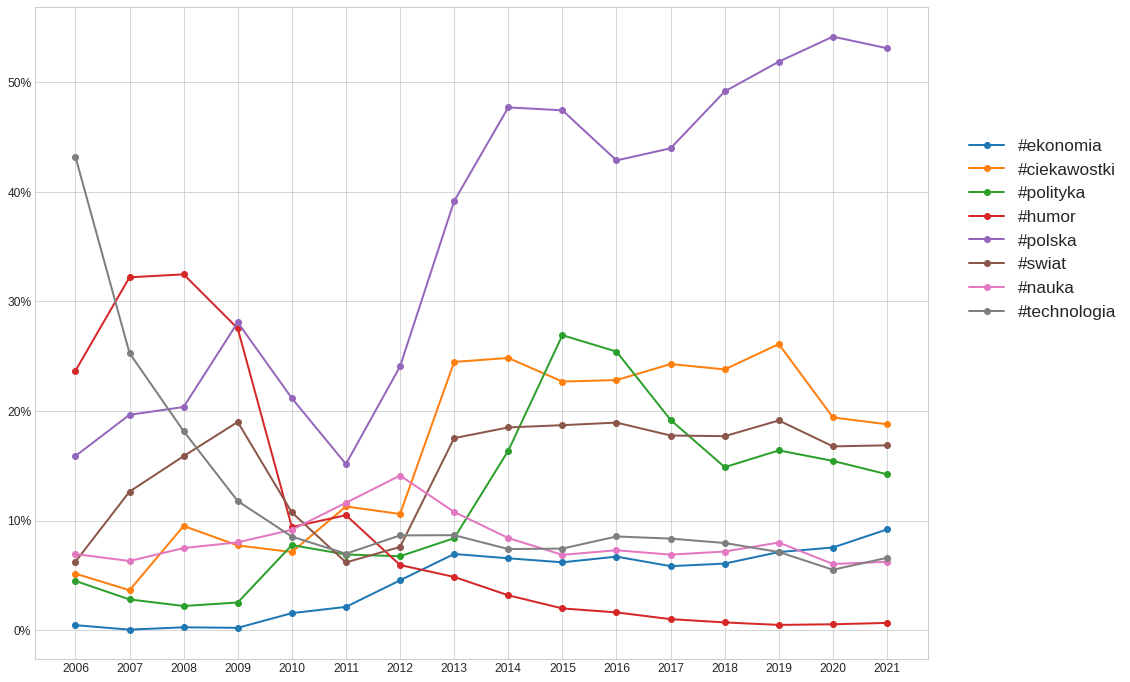

In [200]:
tags = ['#ekonomia', '#ciekawostki', '#polityka', '#humor',  '#polska', '#swiat', 
        '#nauka', '#technologia']

df = df_tags.copy()
df['n_perc'] = df['n_perc']*100
df['year'] = df['year'].apply(lambda x: str(x))

plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(16, 12))

for tag in tags:
    ax.plot('year', 'n_perc', data=df[df['tag'] == tag], linewidth=2, marker='o', label=tag)

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

fig.legend(loc='lower center', bbox_to_anchor=(1, 0.5), fontsize='xx-large')

plt.savefig('images/popular_tags_series.png', dpi=100, transparent=False, bbox_inches='tight')
plt.show()

#### Tags - WordCloud

In [37]:
tags = [tag for record in df_links[df_links['year'] == 2021].tags for tag in record ]

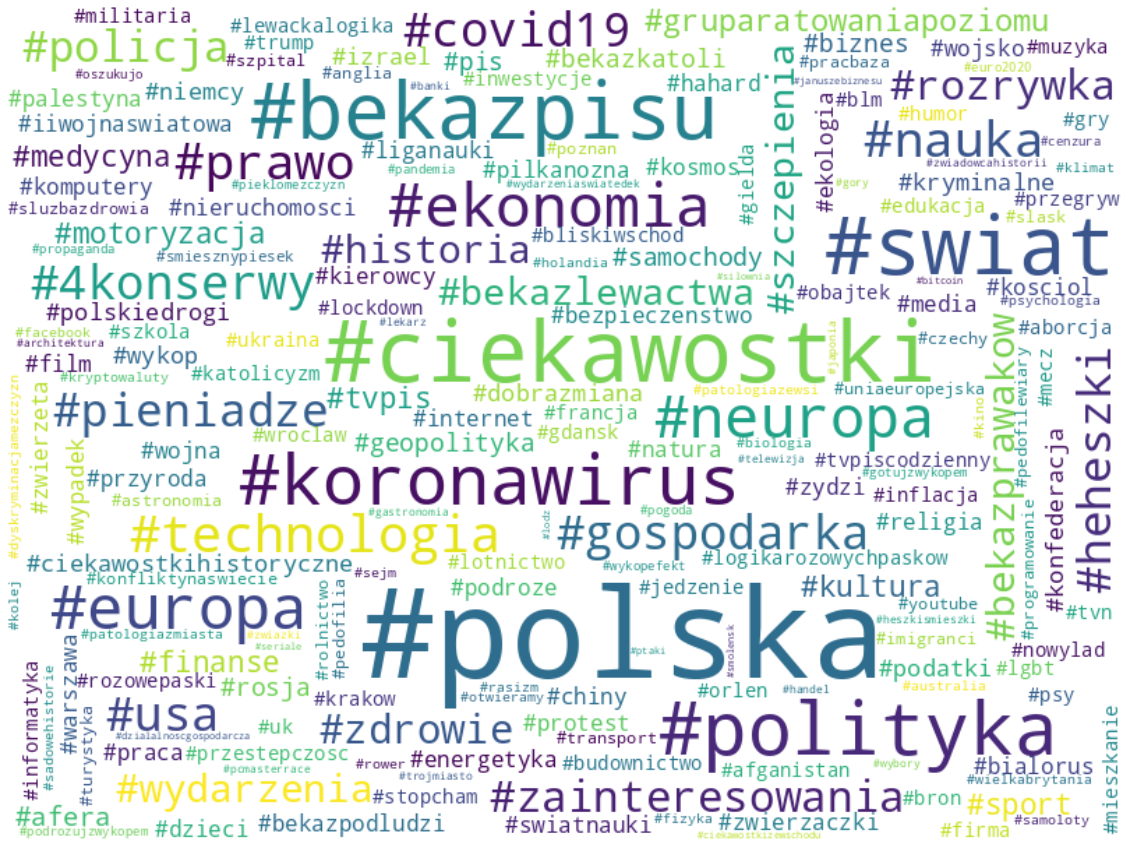

In [38]:
wc3 = WordCloud(max_font_size=90, background_color='white', width=800, height=600) \
    .generate_from_frequencies(Counter(tags))

plt.figure(figsize=(20, 20))
plt.imshow(wc3, interpolation="bilinear")
plt.axis("off")
plt.show()

#### What are the most popular sources?

In [39]:
from urllib.parse import urlparse

def extract_domain(url):
    domain = urlparse(url).netloc
    return domain[4:] if domain.startswith('www.') else domain

def modify_domains(domain):
    if domain in ['youtube.com', 'youtu.be', 'pl.youtube.com' ]:
        return 'youtube.com'
    return domain

In [40]:
df_links['source_domain'] = df_links.source_url.apply(lambda x: modify_domains(extract_domain(x)))

In [41]:
df_domains = df_links[['id', 'year', 'source_domain']] \
    .groupby(['year', 'source_domain']) \
    .agg(n=('id', 'count')) \
    .reset_index()

popular_domains = ['wykop.pl', 'streamable.com', 'twitter.com', 'facebook.com', 'youtube.com']
df_domains = df_domains[~df_domains['source_domain'].isin(popular_domains)]

df_domains['rank'] = df_domains.groupby(by=['year'])['n'] \
    .transform(lambda x: x.rank(method='first', ascending=False))

In [42]:
df_popular = df_domains[df_domains['rank'] <= 5].reset_index()
df_popular['item'] = df_popular.apply(lambda x: (x.source_domain, x.n), axis=1)

for year, tags in df_popular.groupby(['year'])['item'].apply(list).items():
    print(year, ' ', end='')
    for domain, n in sorted(tags, key=lambda x: x[1], reverse=True):
        print('{:s} ({:d}) '.format(domain, n), end='')
    print()

2006  serwisy.gazeta.pl (67) wiadomosci.gazeta.pl (65) wiadomosci.onet.pl (31) gospodarka.gazeta.pl (26) video.google.com (25) 
2007  wiadomosci.gazeta.pl (100) wiadomosci.onet.pl (57) di.com.pl (48) wiadomosci24.pl (48) kopalniawiedzy.pl (43) 
2008  dziennik.pl (77) webhosting.pl (51) rp.pl (49) joemonster.org (45) eioba.pl (44) 
2009  pokazywarka.pl (511) rp.pl (118) wiadomosci.onet.pl (90) dziennik.pl (83) imgur.com (69) 
2010  pokazywarka.pl (456) i.imgur.com (256) rp.pl (127) wiadomosci.onet.pl (98) vimeo.com (85) 
2011  i.imgur.com (836) pokazywarka.pl (784) wiadomosci.onet.pl (186) liveleak.com (180) wiadomosci.gazeta.pl (180) 
2012  pokazywarka.pl (429) liveleak.com (319) tvn24.pl (244) wiadomosci.gazeta.pl (244) rp.pl (224) 
2013  liveleak.com (672) tvn24.pl (367) pokazywarka.pl (286) wiadomosci.gazeta.pl (258) i.imgur.com (240) 
2014  liveleak.com (625) wpolityce.pl (412) tvn24.pl (383) natemat.pl (300) niezalezna.pl (294) 
2015  wpolityce.pl (627) liveleak.com (603) niezalez

### Which tags go together the most?

Association rule learning

#### Data Prepration

In [43]:
df_tags = df_links[df_links.year == 2020].copy()

df_tags.tags = df_tags.tags.apply(lambda tags: list(set(tags)))
df_tags = df_tags[['id', 'tags']].explode(['tags']) \
    .rename(columns={'tags': 'tag'})
df_tags['tag'] = df_tags['tag'].apply(lambda x: x.lstrip('#'))
df_tags = df_tags[df_tags.tag != '']
df_tags['n'] = 1

In [44]:
df_tags_aggr = df_tags.groupby(['tag']) \
    .agg(n=('id', 'count')) \
    .reset_index()

popular_tags = set(df_tags_aggr[df_tags_aggr['n'] > 100]['tag'].to_list())

print(f'There are {len(popular_tags)} popular tags.')

There are 219 popular tags.


In [45]:
# Keep only popular tags & remove links without any tags
df_tags = df_tags[df_tags['tag'].apply(lambda tag: tag in popular_tags)]

#### Assocation rule maining

In [48]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [49]:
basket = df_tags.groupby(['id', 'tag'])['n'].sum()\
    .unstack().reset_index().fillna(0)\
    .set_index('id')

In [50]:
frequent_itemsets = apriori(basket, min_support=0.025, use_colnames=True)

In [51]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(2019ncov),(koronawirus),0.041212,0.212588,0.039163,0.950289,4.470107,0.030402,15.839809
1,(koronawirus),(2019ncov),0.212588,0.041212,0.039163,0.184222,4.470107,0.030402,1.175305
2,(bekazpisu),(neuropa),0.132808,0.087832,0.056649,0.426547,4.856413,0.044984,1.590659
3,(neuropa),(bekazpisu),0.087832,0.132808,0.056649,0.644969,4.856413,0.044984,2.442581
4,(bekazpisu),(polityka),0.132808,0.155844,0.072276,0.544215,3.492062,0.051579,1.852095


In [52]:
rules.sort_values(['confidence'], ascending=False).head(n=30)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(2019ncov),(koronawirus),0.041212,0.212588,0.039163,0.950289,4.470107,0.030402,15.839809
27,(epidemia),(koronawirus),0.037948,0.212588,0.034971,0.921532,4.334834,0.026903,10.034784
19,(covid19),(koronawirus),0.079565,0.212588,0.071942,0.904192,4.253267,0.055028,8.218617
86,"(covid19, polska)",(koronawirus),0.047096,0.212588,0.042475,0.901872,4.242354,0.032463,8.024301
61,"(koronawirus, bekazpisu)",(polska),0.027991,0.547215,0.025013,0.893617,1.633027,0.009696,4.256177
6,(bekazpisu),(polska),0.132808,0.547215,0.116394,0.876413,1.601587,0.043720,3.663680
79,"(bekazpisu, polityka)",(polska),0.072276,0.547215,0.063128,0.873434,1.596144,0.023578,3.577472
73,"(bekazpisu, neuropa)",(polska),0.056649,0.547215,0.048502,0.856182,1.564616,0.017503,3.148311
104,"(bekazpisu, polityka, neuropa)",(polska),0.038091,0.547215,0.032517,0.853659,1.560005,0.011673,3.094029
97,"(wybory, polityka)",(polska),0.032565,0.547215,0.026800,0.822970,1.503924,0.008980,2.557673


### What are the most popular words in titles?

In [53]:
from wordcloud import WordCloud

In [54]:
import re
import string

re_punc = re.compile('[%s]' % re.escape(string.punctuation))
re_print = re.compile(r'[^%s]' % re.escape(string.printable + 'ęóąśłżźń'))
re_tokens = re.compile(r'[a-zęóąśłżźńA-ZĘÓĄŚŁŻŹŃ\']+')

def tokenize(text, lower_case=True, drop_non_printable=True):
    tokens = re_tokens.findall(text)
    tokens = [ re_punc.sub('', token) for token in tokens ]
    if drop_non_printable: 
        words = [ re_print.sub('', token) for token in tokens ]
    if lower_case:
        words = [ token.lower() for token in tokens ]
    return words

In [55]:
# source: https://pl.wikipedia.org/wiki/Wikipedia:Stopwords

stopwords = 'a, aby, ach, acz, aczkolwiek, aj, albo, ale, ależ, ani, aż, bardziej, bardzo, bo, bowiem, by, byli, bynajmniej, być, był, była, było, były, będzie, będą, cali, cała, cały, ci, cię, ciebie, co, cokolwiek, coś, czasami, czasem, czemu, czy, czyli, daleko, dla, dlaczego, dlatego, do, dobrze, dokąd, dość, dużo, dwa, dwaj, dwie, dwoje, dziś, dzisiaj, gdy, gdyby, gdyż, gdzie, gdziekolwiek, gdzieś, i, ich, ile, im, inna, inne, inny, innych, iż, ja, ją, jak, jaka, jakaś, jakby, jaki, jakichś, jakie, jakiś, jakiż, jakkolwiek, jako, jakoś, je, jeden, jedna, jedno, jednak, jednakże, jego, jej, jemu, jest, jestem, jeszcze, jeśli, jeżeli, już, ją, każdy, kiedy, kilka, kimś, kto, ktokolwiek, ktoś, która, które, którego, której, który, których, którym, którzy, ku, lat, lecz, lub, ma, mają, mało, mam, mi, mimo, między, mną, mnie, mogą, moi, moim, moja, moje, może, możliwe, można, mój, mu, musi, my, na, nad, nam, nami, nas, nasi, nasz, nasza, nasze, naszego, naszych, natomiast, natychmiast, nawet, nią, nic, nich, nie, niech, niego, niej, niemu, nigdy, nim, nimi, niż, no, o, obok, od, około, on, ona, one, oni, ono, oraz, oto, owszem, pan, pana, pani, po, pod, podczas, pomimo, ponad, ponieważ, powinien, powinna, powinni, powinno, poza, prawie, przecież, przed, przede, przedtem, przez, przy, roku, również, sama, są, się, skąd, sobie, sobą, sposób, swoje, ta, tak, taka, taki, takie, także, tam, te, tego, tej, temu, ten, teraz, też, to, tobą, tobie, toteż, trzeba, tu, tutaj, twoi, twoim, twoja, twoje, twym, twój, ty, tych, tylko, tym, u, w, wam, wami, was, wasz, wasza, wasze, we, według, wiele, wielu, więc, więcej, wszyscy, wszystkich, wszystkie, wszystkim, wszystko, wtedy, wy, właśnie, z, za, zapewne, zawsze, ze, zł, znowu, znów, został, żaden, żadna, żadne, żadnych, że, żeby'
stopwords = set([ word.strip() for word in stopwords.split(',') ])

In [56]:
re_html_entity = re.compile(r'&.*?;')

def preprocess(title, stopwords):
    if not isinstance(title, str): return ''
    title = re_html_entity.sub('', title)
    tokens = tokenize(title)
    tokens = [ token for token in tokens if len(token) >= 2 and token not in stopwords ]
    return ' '.join(tokens)

In [57]:
df = df_links[['title', 'year']].copy()

df['title'] = df['title'].apply(lambda title: preprocess(title, stopwords))

In [60]:
titles = ' '.join(df[df['year'] == 2021].title)

wc3 = WordCloud(max_font_size=90, background_color='white', 
                width=800, height=600) \
    .generate(titles)

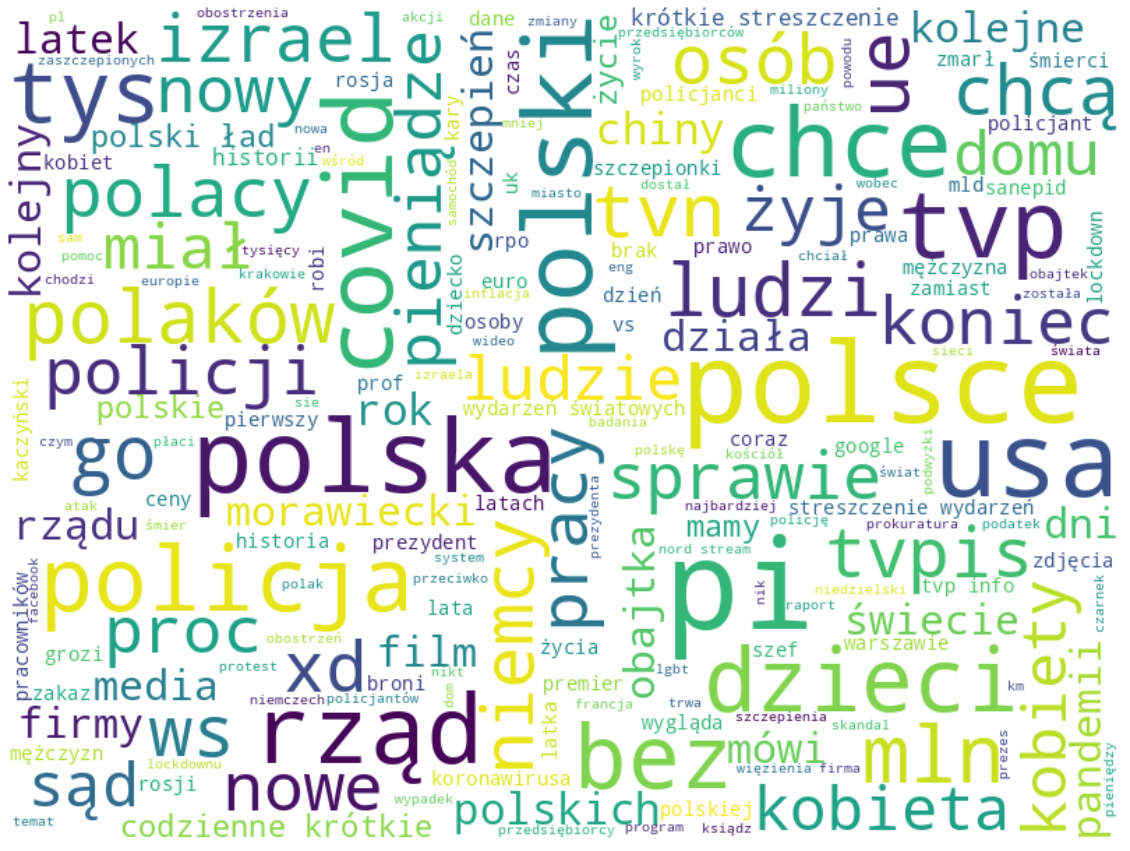

In [61]:
plt.figure(figsize=(20, 20))
plt.imshow(wc3, interpolation="bilinear")
plt.axis("off")
plt.show()

### Which users' links are the most upvoted?

In [62]:
df = df_links.copy()

df['author'] = df.author.apply(lambda author: author['login'])

In [63]:
df_authors = df[['id', 'year', 'author']] \
    .groupby(['year', 'author']) \
    .agg(n=('id', 'count')) \
    .reset_index()

df_authors['rank'] = df_authors.groupby(by=['year'])['n'] \
    .transform(lambda x: x.rank(method='first', ascending=False))

In [64]:
df_popular = df_authors[df_authors['rank'] <= 5].reset_index()
df_popular['item'] = df_popular.apply(lambda x: (x.author, x.n), axis=1)

for year, tags in df_popular.groupby(['year'])['item'].apply(list).items():
    print(year, ' ', end='')
    for domain, n in sorted(tags, key=lambda x: x[1], reverse=True):
        print('{:13.12s}-{:5d} | '.format(domain, n), end='')
    print()

2006  fuutott      -   46 | losamorales  -   39 | adas         -   38 | gumik        -   30 | mieteck      -   27 | 
2007  NamalowanyPr -   60 | michuk       -   52 | mintaj4      -   34 | brocha       -   27 | jaceks       -   26 | 
2008  rybeczka     -   68 | _tomek_      -   58 | tomaszs      -   40 | einer        -   38 | NowyPremier  -   35 | 
2009  _tomek_      -  144 | kaszpirofsky -  118 | NiEb0        -  108 | piotrus_72   -   94 | leffort      -   61 | 
2010  reddigg      -  106 | kaszpirofsky -   87 | kubatre1     -   84 | maxmaxiu     -   79 | piotrus_72   -   77 | 
2011  reddigg      -  453 | kubatre1     -  236 | abram66      -  148 | D........... -  139 | rzep         -  121 | 
2012  kajakkajak   -  217 | GraveDigger  -  185 | siwymaka     -  174 | Ardai        -  148 | rzep         -  127 | 
2013  p........... -  220 | c....o       -  206 | GraveDigger  -  205 | Pierdyliard  -  181 | vanMax       -  157 | 
2014  darosoldier  - 1125 | sportingkiel -  739 | reflex1      -

In [67]:
# User with at least 100 links

df[df.year == 2020].groupby(['author'])\
    .agg(mean_votes=('vote_count', 'mean'), n=('id', 'count'))\
    .query('n >= 100') \
    .sort_values(['mean_votes'], ascending=False).head(5)

,mean_votes,n
author,,
Radek41,2018.725806,124
b....a,1615.314433,194
jaxonxst,1280.400000,130
tomasztomasz1234,1204.654237,590
Takiseprzecietniak,1037.768559,229
